##**Library Import**

In [1]:
from google.colab import drive

In [2]:
drive = drive.mount('/content/drive')
data_dir = 'drive/MyDrive/kaggle_data'

Mounted at /content/drive


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##**GPU & Seed Setting**

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.manual_seed(0)

In [6]:
# Load data
train_x = pd.read_csv(f'{data_dir}/train_x.csv')
train_y = pd.read_csv(f'{data_dir}/train_y.csv')
val_x = pd.read_csv(f'{data_dir}/val_x.csv')
val_y = pd.read_csv(f'{data_dir}/val_y.csv')

##**EDA**

**Dataset Structure**  
The dataset includes columns representing 8 demographic groups and various types of toxicity indicators:  

- Demographic Groups: male, female, LGBTQ, christian, muslim, other_religions, black, white
- Toxicity Indicators: identity_any, severe_toxicity, obscene, threat, insult, identity_attack, sexual_explicit
- Target Variable: y (indicating the toxicity level)

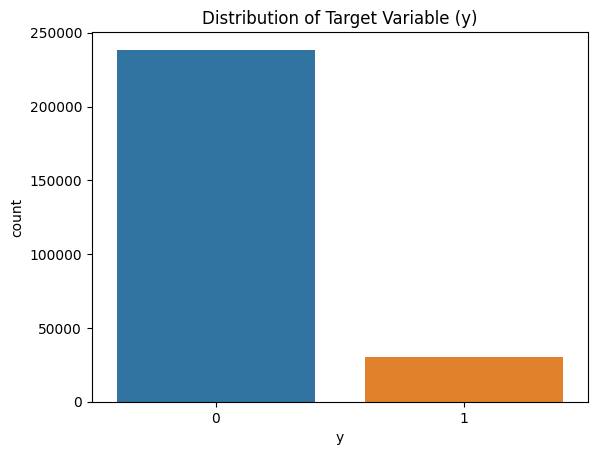

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='y', data=train_y)
plt.title('Distribution of Target Variable (y)')
plt.show()

From the chart, it is evident that there is a significant class imbalance, with non-toxic comments (label 0) greatly outnumbering the toxic comments (label 1). We might need to do resampling later.

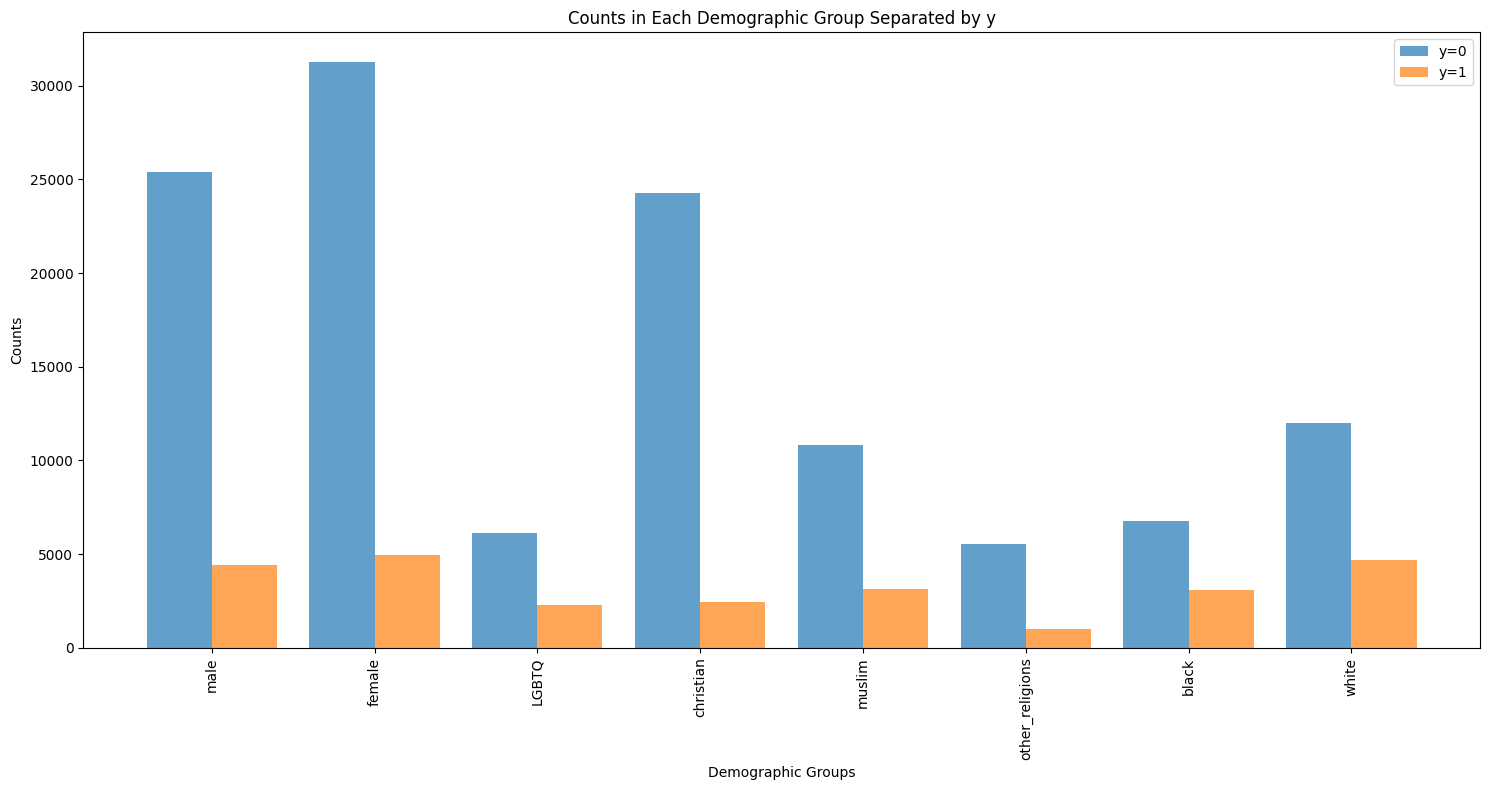

In [ ]:
# Specify the demographic columns
demographic_columns = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

# Count the occurrences where each column is 1, separated by the 'y' value
counts_y_0 = train_y[train_y['y'] == 0][demographic_columns].sum()
counts_y_1 = train_y[train_y['y'] == 1][demographic_columns].sum()

# Set the positions and width for the bars
positions = range(len(demographic_columns))
width = 0.4

# Plotting both counts in the same plot, but with an offset for the x position
plt.figure(figsize=(15, 8))
plt.bar(positions, counts_y_0, width, alpha=0.7, label='y=0')
plt.bar([p + width for p in positions], counts_y_1, width, alpha=0.7, label='y=1')

# Adding labels, title, and legend
plt.xlabel('Demographic Groups')
plt.ylabel('Counts')
plt.title('Counts in Each Demographic Group Separated by y')
plt.xticks([p + width / 2 for p in positions], demographic_columns, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

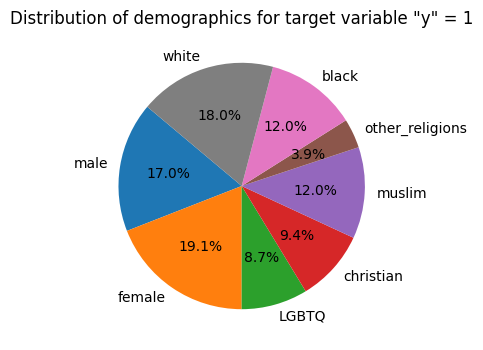

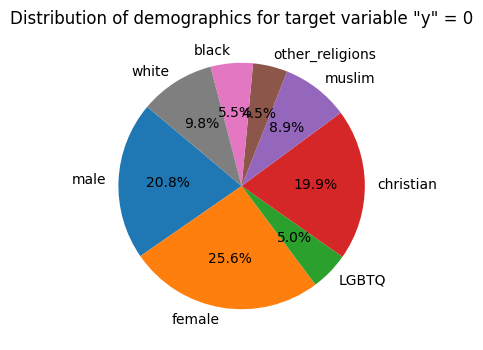

In [ ]:
# Calculate the sums of each demographic group by the classes of 'y'
distribution = train_y[demographic_columns].groupby(train_y['y']).sum()

# This code snippet will generate two pie charts, one for each class of 'y'
for value in train_y['y'].unique():
    plt.figure(figsize=(8, 4))
    plt.pie(distribution.loc[value], labels=distribution.columns, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of demographics for target variable "y" = {value}')
    plt.show()

1. The male and female groups show a large number of non-toxic comments compared to toxic comments, with male having slightly more non-toxic comments than female.  
2. The LGBTQ group has a lower count of non-toxic comments relative to the male and female groups but still far more than its toxic counterparts.  
3. Christian is the demographic with the highest count of non-toxic comments and a relatively small proportion of toxic comments.  
4. The Muslim group shows a smaller number of non-toxic comments than the Christian group but more than the LGBTQ group, with toxic comments also being a small proportion.
5. Other_religions shows fewer non-toxic comments than Muslim and a similar proportion of toxic comments.  
6. The black group has a lower count of non-toxic comments compared to other_religions, with a similar proportion of toxic comments.  
7. The white group shows a large number of non-toxic comments, comparable to the Christian group, and a similar proportion of toxic comments.

##**Research**

First, we tried to look into Baseline Model Performance.  
  
[Baseline Model]
 - *Training WGA: 0.709*
 - *Test WGA: 0.730*

So we started from improving Baseline Model by the following improvement to learn more complex patterns in the data:  

```
class EnhancedMLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(EnhancedMLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x
```

1. Additional Hidden Layer & Dimensionality Reduction: Introduce an additional hidden layer (self.fc2) that reduces the dimensionality from hidden_dim to hidden_dim // 2 to add complexity that can potentially capture more abstract representations of the input data.

2. Batch Normalization: It incorporates batch normalization layers (self.bn1 and self.bn2) after each fully connected layer except the last to improve the stability and speed of the network's training process.

[Enhanced Baseline Model]
 - *Training WGA: 0.741*
 - *Test WGA: 0.765*  

But since then, we couldn't improve the model performance any better by just adding more complexity into the architecture.

***

Then we read and decided to use 3 essaies to develope better model implementation:
 - A Source-Criticism Debiasing Method for GloVe Embeddings by Hope McGovern
 - Deep learning for religious toxic content
classification by Ahmed Abbasi, Abdul Rehman Javed, Farkhund Iqbal, Natalia Kryvinska & Zunera Jalil1
 - Retracted: An Automated Toxicity Classification on Social Media Using LSTM and Word Embedding by Hindawi

The retracted paper "An Automated Toxicity Classification on Social Media Using LSTM and Word Embedding" had proposed using LSTM models combined with GloVe word embeddings to improve the accuracy and F1-score in classifying toxic comments on social media.
  
Despite the retraction, the idea of switching to models that use embeddings like GloVe with LSTM, GRU, or CNN is typically because these models can capture the sequential and contextual nuances of language better than simpler baseline models.
  
LSTM and GRU, in particular, are adept at handling sequences like sentences, and word embeddings provide a dense, meaningful representation of words that can capture semantic similarities. This combination can lead to better performance in tasks like toxicity classification where the context of words is crucial.  

##**Data Preprocessing**  
Tokenize
***

In [7]:
# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

In [8]:
train_x['string'] = train_x['string'].apply(preprocess_text)
val_x['string'] = val_x['string'].apply(preprocess_text)

In [9]:
# Tokenize
train_x['tokens'] = train_x['string'].apply(word_tokenize)
val_x['tokens'] = val_x['string'].apply(word_tokenize)

Creating Glove Embedding Matrix
***
The GloVe embeddings file glove.840B.300d.txt is derived from the Common Crawl dataset, which contains 840 billion tokens and a vocabulary of 2.2 million words. The embeddings are cased, preserving the distinction between uppercase and lowercase letters, and each word is represented by a 300-dimensional vector. This extensive collection of word vectors is beneficial for a wide range of natural language processing tasks, providing rich, pre-trained word representations that capture semantic and syntactic word similarities.

In [10]:
# Load GloVe embeddings
def load_glove_embeddings(path, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word_index:
                try:
                    vector = np.asarray(values[1:], dtype='float32')
                    embedding_matrix[word_index[word]] = vector[:embedding_dim]
                except ValueError:
                    continue  # Skip lines that don't have the correct format
    return embedding_matrix

In [11]:
word_index = {word: idx + 1 for idx, word in enumerate(set([w for words in train_x['tokens'] for w in words]))}
glove_embeddings = load_glove_embeddings(f'drive/MyDrive//glove.840B.300d.txt', word_index, 300)

TextDataset Class & Tokens to Indices
***

In [12]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(text) for text in texts]  # Convert to tensor here
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [13]:
def tokens_to_indices(tokens, word_index):
    return [word_index.get(word, 0) for word in tokens]

In [14]:
train_x['indices'] = train_x['tokens'].apply(lambda tokens: tokens_to_indices(tokens, word_index))
val_x['indices'] = val_x['tokens'].apply(lambda tokens: tokens_to_indices(tokens, word_index))

In [ ]:
train_x.head()

,index,string,tokens,indices
0,0,even up here blacks,"[even, up, here, blacks]","[16243, 107154, 119106, 42349]"
1,1,blame men there s always an excuse to blame me...,"[blame, men, there, s, always, an, excuse, to,...","[66282, 13846, 93675, 72563, 81658, 123010, 37..."
2,2,you have no business making any comments on th...,"[you, have, no, business, making, any, comment...","[5166, 87120, 76402, 8171, 117445, 75041, 1077..."
3,3,let s get the black folks and the white folks...,"[let, s, get, the, black, folks, and, the, whi...","[60132, 72563, 41174, 86242, 85658, 17497, 744..."
4,4,i guess the issue is people not willing to put...,"[i, guess, the, issue, is, people, not, willin...","[62857, 89188, 86242, 40684, 114114, 55297, 88..."


In [ ]:
train_y.head()

,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1
1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


Check Embedding Completion Status
***

In [15]:
from collections import Counter

def check_coverage(vocab, embeddings_index, word_index):
    known_words = {}
    unknown_words = {}
    num_known_words = 0
    num_unknown_words = 0

    for word in vocab.keys():
        try:
            # Get the index of the word from word_index
            idx = word_index[word]
            # Retrieve the embedding vector for the word using its index
            word_embedding = embeddings_index[idx]
            # If the embedding vector is not just zeros, count the word as known
            if np.count_nonzero(word_embedding) > 0:
                known_words[word] = word_embedding
                num_known_words += vocab[word]
            else:
                unknown_words[word] = vocab[word]
                num_unknown_words += vocab[word]
        except KeyError:
            unknown_words[word] = vocab[word]
            num_unknown_words += vocab[word]

    print(f"Found embeddings for {round((num_known_words / (num_known_words + num_unknown_words)) * 100, 2)}% of vocab")
    print(f"Found embeddings for  {num_known_words} words in the dataset")
    print(f"Did not find embeddings for {round((num_unknown_words / (num_known_words + num_unknown_words)) * 100, 2)}% of vocab")
    print(f"Did not find embeddings for {num_unknown_words} words in the dataset")
    return known_words, unknown_words

# Build a vocabulary dictionary from your dataset: word -> frequency
vocab = Counter()
for tokens_list in train_x['tokens']:
    vocab.update(tokens_list)

# Now call the function with your vocab, embeddings array, and word index
known_words, unknown_words = check_coverage(vocab, glove_embeddings, word_index)

Found embeddings for 99.54% of vocab
Found embeddings for  16732786 words in the dataset
Did not find embeddings for 0.46% of vocab
Did not find embeddings for 77710 words in the dataset


The embedding coverage check indicates that the GloVe embeddings provide a robust representation for this dataset, with 99.54% of the vocabulary found in the embeddings index. This high coverage means that the vast majority of words used in the dataset have a pre-trained vector representation, which is essential for creating meaningful input features for models like LSTM, GRU, or CNN.

**Create Train & Validation Datasets and DataLoader**
---

In [16]:
# Create datasets
train_dataset = TextDataset(list(train_x['indices']), list(train_y['y']))
val_dataset = TextDataset(list(val_x['indices']), list(val_y['y']))

In [17]:
from torch.nn.utils.rnn import pad_sequence
from torch.autograd import Variable

# Helper function to pad sequences and sort the batch
def pad_and_sort_batch(DataLoaderBatch):
    if isinstance(DataLoaderBatch[0], tuple):
        # If DataLoaderBatch items are tuples (sequence, label), unpack them
        sequences, labels = zip(*DataLoaderBatch)
        labels = torch.stack(labels)  # Ensure labels are a tensor as well
    else:
        # If DataLoaderBatch items are just sequences (as in test data), don't unpack
        sequences = DataLoaderBatch
        labels = None  # No labels in test data

    sequences_padded = pad_sequence(sequences, batch_first=True)
    return sequences_padded, labels

In [18]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=pad_and_sort_batch)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=pad_and_sort_batch)

## **Training & Validation**  

1. Embedding Method & Layer: Glove(glove.840B.300d.txt => Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors)
  
2. [Training Models]
  - CNN
  - LSTM
  - Bidirection LSTM
  - Bidirection GRU
  - Dynamic Architecture: BiGRU + CNN

**1. CNN**
---

In [19]:
class CNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_filters, filter_sizes, output_dim, dropout):
        super(CNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))

        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_matrix.shape[1]))
            for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add a channel dimension
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return self.sigmoid(x)

[ Model Setting ]  
3 Convoloutional Layer with Kernel size (2, 3, 4)  
3 Pooling Layers (following each convolutional layer)   
Dropout rate: 0.2

In [20]:
cnn_model = CNNClassifier(glove_embeddings, num_filters=128, filter_sizes=[2,3,4], output_dim=1, dropout=0.2)
cnn_model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
num_epochs = 15

In [21]:
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training and Validation Loops with Subgroup Accuracy Calculation
for epoch in range(num_epochs):
    cnn_model.train()
    total_loss = 0

    # Training
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        output = cnn_model(sequences)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}')

    # Validation
    cnn_model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            output = cnn_model(sequences)
            predicted = (output.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(output.squeeze(), labels.float())
            total_loss += loss.item()

    print(f'Epoch {epoch+1}, Validation Accuracy: {correct / total}, Validation Loss: {total_loss / len(val_loader)}')

    # Subgroup Accuracy Calculation
    subgroup_accuracy = {}
    with torch.no_grad():
        for subgroup in ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']:
            total = 0
            correct = 0
            subgroup_indices = val_y[subgroup] == 1
            subgroup_val_x = val_x[subgroup_indices]
            subgroup_val_y = val_y['y'][subgroup_indices]
            subgroup_dataset = TextDataset(list(subgroup_val_x['indices']), list(subgroup_val_y))
            subgroup_loader = DataLoader(subgroup_dataset, batch_size=32, shuffle=False, collate_fn=pad_and_sort_batch)

            for sequences, labels in subgroup_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                output = cnn_model(sequences)
                predicted = (output.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            subgroup_accuracy[subgroup] = correct / total if total > 0 else 0

    print(f"Epoch {epoch+1}, Subgroup Accuracies: {subgroup_accuracy}")
    print(f"WGA: {min(subgroup_accuracy.values())}")

    # Early Stopping Check
    if (total_loss / len(val_loader)) < best_val_loss:
        best_val_loss = (total_loss / len(val_loader))
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Stopping early due to no improvement in validation loss")
        break

Epoch 1, Training Loss: 0.21958046910538206
Epoch 1, Validation Accuracy: 0.9211819389110226, Validation Loss: 0.1923036553112969
Epoch 1, Subgroup Accuracies: {'male': 0.895697796432319, 'female': 0.9023934815820743, 'LGBTQ': 0.814687714481812, 'christian': 0.9320879120879121, 'muslim': 0.8199052132701422, 'other_religions': 0.8640973630831643, 'black': 0.7542372881355932, 'white': 0.781304499476805}
WGA: 0.7542372881355932
Epoch 2, Training Loss: 0.1927759969637124
Epoch 2, Validation Accuracy: 0.9184373616644533, Validation Loss: 0.19813074891344976
Epoch 2, Subgroup Accuracies: {'male': 0.8898216159496327, 'female': 0.8964522152435919, 'LGBTQ': 0.7940974605353466, 'christian': 0.9296703296703297, 'muslim': 0.8161137440758294, 'other_religions': 0.8640973630831643, 'black': 0.7481840193704601, 'white': 0.7642134635507499}
WGA: 0.7481840193704601
Epoch 3, Training Loss: 0.17898581988691262
Epoch 3, Validation Accuracy: 0.9214918105356352, Validation Loss: 0.19014601402068879
Epoch 3,

**2. LSTM**
---

In [ ]:
# Define LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)
        return self.sigmoid(out)

[ Model Setting ]  
1 LSTM Layer  
Dropout rate: None

In [ ]:
model = LSTMClassifier(glove_embeddings, hidden_dim=128, output_dim=1)
model.to(device)
model.lstm.flatten_parameters()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
num_epochs = 10

In [ ]:
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training and Validation Loops with Subgroup Accuracy Calculation
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Training
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(sequences)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}')

    # Validation
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            output = model(sequences)
            predicted = (output.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(output.squeeze(), labels.float())
            total_loss += loss.item()

    print(f'Epoch {epoch+1}, Validation Accuracy: {correct / total}, Validation Loss: {total_loss / len(val_loader)}')

    # Subgroup Accuracy Calculation
    subgroup_accuracy = {}
    with torch.no_grad():
        for subgroup in ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']:
            total = 0
            correct = 0
            subgroup_indices = val_y[subgroup] == 1
            subgroup_val_x = val_x[subgroup_indices]
            subgroup_val_y = val_y['y'][subgroup_indices]
            subgroup_dataset = TextDataset(list(subgroup_val_x['indices']), list(subgroup_val_y))
            subgroup_loader = DataLoader(subgroup_dataset, batch_size=32, shuffle=False, collate_fn=pad_and_sort_batch)

            for sequences, labels in subgroup_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                output = model(sequences)
                predicted = (output.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            subgroup_accuracy[subgroup] = correct / total if total > 0 else 0

    print(f"Epoch {epoch+1}, Subgroup Accuracies: {subgroup_accuracy}")
    print(f"WGA: {min(subgroup_accuracy.values())}")

    # Early Stopping Check
    if (total_loss / len(val_loader)) < best_val_loss:
        best_val_loss = (total_loss / len(val_loader))
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Stopping early due to no improvement in validation loss")
        break

Epoch 1, Training Loss: 0.35738498419097897
Epoch 1, Validation Accuracy: 0.8881142098273572, Validation Loss: 0.3497257287808731
Epoch 1, Subgroup Accuracies: {'male': 0.8499475341028332, 'female': 0.8691223900865728, 'LGBTQ': 0.7542896362388469, 'christian': 0.9156043956043955, 'muslim': 0.7573459715639811, 'other_religions': 0.8356997971602435, 'black': 0.677360774818402, 'white': 0.7028252528775724}
WGA: 0.677360774818402
Epoch 2, Training Loss: 0.30635283966783566
Epoch 2, Validation Accuracy: 0.9062638335546702, Validation Loss: 0.22617161156094007
Epoch 2, Subgroup Accuracies: {'male': 0.8738719832109129, 'female': 0.8816839246307927, 'LGBTQ': 0.7776252573781743, 'christian': 0.9221978021978022, 'muslim': 0.7772511848341233, 'other_religions': 0.8438133874239351, 'black': 0.7221549636803875, 'white': 0.7478200209277991}
WGA: 0.7221549636803875
Epoch 3, Training Loss: 0.21083908852058633
Epoch 3, Validation Accuracy: 0.9210048694112439, Validation Loss: 0.19558602786165172
Epoch 

**3. Bidirectional LSTM**
---

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # hidden_dim * 2 because of bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)
        return self.sigmoid(out)

[ Model Setting ]  
2 LSTM Layer  
Dropout rate: 0.2

In [ ]:
model = LSTMClassifier(glove_embeddings, hidden_dim=128, output_dim=1)
model.to(device)
model.lstm.flatten_parameters()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
num_epochs = 10

In [ ]:
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training and Validation Loops with Subgroup Accuracy Calculation
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Training
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(sequences)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}')

    # Validation
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            output = model(sequences)
            predicted = (output.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(output.squeeze(), labels.float())
            total_loss += loss.item()

    print(f'Epoch {epoch+1}, Validation Accuracy: {correct / total}, Validation Loss: {total_loss / len(val_loader)}')

    # Subgroup Accuracy Calculation
    subgroup_accuracy = {}
    with torch.no_grad():
        for subgroup in ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']:
            total = 0
            correct = 0
            subgroup_indices = val_y[subgroup] == 1
            subgroup_val_x = val_x[subgroup_indices]
            subgroup_val_y = val_y['y'][subgroup_indices]
            subgroup_dataset = TextDataset(list(subgroup_val_x['indices']), list(subgroup_val_y))
            subgroup_loader = DataLoader(subgroup_dataset, batch_size=32, shuffle=False, collate_fn=pad_and_sort_batch)

            for sequences, labels in subgroup_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                output = model(sequences)
                predicted = (output.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            subgroup_accuracy[subgroup] = correct / total if total > 0 else 0

    print(f"Epoch {epoch+1}, Subgroup Accuracies: {subgroup_accuracy}")
    print(f"WGA: {min(subgroup_accuracy.values())}")

    # Early Stopping Check
    if (total_loss / len(val_loader)) < best_val_loss:
        best_val_loss = (total_loss / len(val_loader))
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Stopping early due to no improvement in validation loss")
        break

Epoch 1, Training Loss: 0.35627846893359094
Epoch 1, Validation Accuracy: 0.8881142098273572, Validation Loss: 0.3497790492187112
Epoch 1, Subgroup Accuracies: {'male': 0.8499475341028332, 'female': 0.8691223900865728, 'LGBTQ': 0.7542896362388469, 'christian': 0.9156043956043955, 'muslim': 0.7573459715639811, 'other_religions': 0.8356997971602435, 'black': 0.677360774818402, 'white': 0.7028252528775724}
WGA: 0.677360774818402
Epoch 2, Training Loss: 0.34967511865380374
Epoch 2, Validation Accuracy: 0.888092076139885, Validation Loss: 0.30606997720265794
Epoch 2, Subgroup Accuracies: {'male': 0.8507869884575027, 'female': 0.8696316414870141, 'LGBTQ': 0.7549759780370625, 'christian': 0.916043956043956, 'muslim': 0.7573459715639811, 'other_religions': 0.834685598377282, 'black': 0.6767554479418886, 'white': 0.7052668294384374}
WGA: 0.6767554479418886
Epoch 3, Training Loss: 0.2328436614557406
Epoch 3, Validation Accuracy: 0.9181938911022577, Validation Loss: 0.20209580321012244
Epoch 3, S

**4. Bidirectional GRU**
---

In [22]:
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))

        self.gru = nn.GRU(embedding_matrix.shape[1], hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.gru(x)

        if self.gru.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        x = self.fc(hidden)
        return self.sigmoid(x)

[ Model Setting ]  
2 GRU Layer  
Dropout rate: 0.2

In [23]:
gru_model = GRUClassifier(glove_embeddings, hidden_dim=128, output_dim=1, n_layers=2, bidirectional=True, dropout=0.2)
gru_model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
num_epochs = 15

In [24]:
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training and Validation Loops with Subgroup Accuracy Calculation
for epoch in range(num_epochs):
    gru_model.train()
    total_loss = 0

    # Training
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        output = gru_model(sequences)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}')

    # Validation
    gru_model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            output = gru_model(sequences)
            predicted = (output.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(output.squeeze(), labels.float())
            total_loss += loss.item()

    print(f'Epoch {epoch+1}, Validation Accuracy: {correct / total}, Validation Loss: {total_loss / len(val_loader)}')

    # Subgroup Accuracy Calculation
    subgroup_accuracy = {}
    with torch.no_grad():
        for subgroup in ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']:
            total = 0
            correct = 0
            subgroup_indices = val_y[subgroup] == 1
            subgroup_val_x = val_x[subgroup_indices]
            subgroup_val_y = val_y['y'][subgroup_indices]
            subgroup_dataset = TextDataset(list(subgroup_val_x['indices']), list(subgroup_val_y))
            subgroup_loader = DataLoader(subgroup_dataset, batch_size=32, shuffle=False, collate_fn=pad_and_sort_batch)

            for sequences, labels in subgroup_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                output = gru_model(sequences)
                predicted = (output.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            subgroup_accuracy[subgroup] = correct / total if total > 0 else 0

    print(f"Epoch {epoch+1}, Subgroup Accuracies: {subgroup_accuracy}")
    print(f"WGA: {min(subgroup_accuracy.values())}")

    # Early Stopping Check
    if (total_loss / len(val_loader)) < best_val_loss:
        best_val_loss = (total_loss / len(val_loader))
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Stopping early due to no improvement in validation loss")
        break

Epoch 1, Training Loss: 0.21364482412811237
Epoch 1, Validation Accuracy: 0.9210270030987162, Validation Loss: 0.19077822902781816
Epoch 1, Subgroup Accuracies: {'male': 0.8938090241343127, 'female': 0.8964522152435919, 'LGBTQ': 0.7940974605353466, 'christian': 0.9276923076923077, 'muslim': 0.8170616113744076, 'other_religions': 0.8620689655172413, 'black': 0.7627118644067796, 'white': 0.7865364492500871}
WGA: 0.7627118644067796
Epoch 2, Training Loss: 0.183346517873196
Epoch 2, Validation Accuracy: 0.9262505533421868, Validation Loss: 0.17760294462201623
Epoch 2, Subgroup Accuracies: {'male': 0.899685204616999, 'female': 0.9071464946528603, 'LGBTQ': 0.8085106382978723, 'christian': 0.9336263736263736, 'muslim': 0.8303317535545024, 'other_religions': 0.8691683569979716, 'black': 0.7681598062953995, 'white': 0.7976979420997559}
WGA: 0.7681598062953995
Epoch 3, Training Loss: 0.17422510232673613
Epoch 3, Validation Accuracy: 0.9264940239043825, Validation Loss: 0.17628441677339332
Epoch 

[ Model Setting ]  
3 GRU Layer  
Dropout rate: 0.2

In [ ]:
gru_model = GRUClassifier(glove_embeddings, hidden_dim=128, output_dim=1, n_layers=3, bidirectional=True, dropout=0.2)
gru_model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.8 ** epoch)
num_epochs = 15

In [ ]:
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training and Validation Loops with Subgroup Accuracy Calculation
for epoch in range(num_epochs):
    gru_model.train()
    total_loss = 0

    # Training
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        output = gru_model(sequences)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}')

    # Validation
    gru_model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            output = gru_model(sequences)
            predicted = (output.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(output.squeeze(), labels.float())
            total_loss += loss.item()

    print(f'Epoch {epoch+1}, Validation Accuracy: {correct / total}, Validation Loss: {total_loss / len(val_loader)}')

    # Subgroup Accuracy Calculation
    subgroup_accuracy = {}
    with torch.no_grad():
        for subgroup in ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']:
            total = 0
            correct = 0
            subgroup_indices = val_y[subgroup] == 1
            subgroup_val_x = val_x[subgroup_indices]
            subgroup_val_y = val_y['y'][subgroup_indices]
            subgroup_dataset = TextDataset(list(subgroup_val_x['indices']), list(subgroup_val_y))
            subgroup_loader = DataLoader(subgroup_dataset, batch_size=32, shuffle=False, collate_fn=pad_and_sort_batch)

            for sequences, labels in subgroup_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                output = gru_model(sequences)
                predicted = (output.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            subgroup_accuracy[subgroup] = correct / total if total > 0 else 0

    print(f"Epoch {epoch+1}, Subgroup Accuracies: {subgroup_accuracy}")
    print(f"WGA: {min(subgroup_accuracy.values())}")

    # Early Stopping Check
    if (total_loss / len(val_loader)) < best_val_loss:
        best_val_loss = (total_loss / len(val_loader))
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Stopping early due to no improvement in validation loss")
        break

Epoch 1, Training Loss: 0.21342698215984596
Epoch 1, Validation Accuracy: 0.9245462594068172, Validation Loss: 0.18355987440942034
Epoch 1, Subgroup Accuracies: {'male': 0.8946484784889822, 'female': 0.9061279918519776, 'LGBTQ': 0.8091969800960879, 'christian': 0.9325274725274725, 'muslim': 0.8208530805687204, 'other_religions': 0.8701825557809331, 'black': 0.7608958837772397, 'white': 0.7945587722357865}
WGA: 0.7608958837772397
Epoch 2, Training Loss: 0.1839021336354606
Epoch 2, Validation Accuracy: 0.9248561310314298, Validation Loss: 0.18158972954724806
Epoch 2, Subgroup Accuracies: {'male': 0.8952780692549842, 'female': 0.9061279918519776, 'LGBTQ': 0.8050789293067948, 'christian': 0.9318681318681319, 'muslim': 0.8213270142180095, 'other_religions': 0.8752535496957403, 'black': 0.7578692493946732, 'white': 0.7889780258109522}
WGA: 0.7578692493946732
Epoch 3, Training Loss: 0.17492913376791608
Epoch 3, Validation Accuracy: 0.9258964143426295, Validation Loss: 0.17746416061569406
Epoc

**5. Dynamic Architecture: BiGRU + CNN**
---

In [ ]:
class BiGRUCNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_filters, output_dim, dropout):
        super(BiGRUCNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=True)

        # Bidirectional GRU
        self.bigru = nn.GRU(embedding_matrix.shape[1], hidden_dim, num_layers=1, bidirectional=True, batch_first=True, dropout=0.1)

        # CNN layer
        self.conv = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=num_filters, kernel_size=3, padding=1)  # hidden_dim * 2 because of bidirectional

        # Global Max and Average Pooling
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(num_filters * 2, output_dim)

        # Dropout and Sigmoid
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)

        # BiGRU layer
        gru_out, _ = self.bigru(x)

        # Transpose for convolution layer
        gru_out = gru_out.transpose(1, 2)

        # Convolution layer
        conv_out = F.relu(self.conv(gru_out))

        # Pooling layers
        max_pooled = self.max_pool(conv_out).squeeze(2)
        avg_pooled = self.avg_pool(conv_out).squeeze(2)

        # Concatenate max and average pooled features
        pooled = torch.cat((max_pooled, avg_pooled), dim=1)

        # Dropout
        pooled = self.dropout(pooled)

        # Fully connected layer
        out = self.fc(pooled)

        return self.sigmoid(out)

[ Model Setting ]  
1 Bidirectional GRU Layer  
1 Convolutional Layer  
1 Global Max Pooling Layer  
1 Global Average Pooling Layer  
Dropout rate: 0.4

In [ ]:
bigru_cnn_model = BiGRUCNNClassifier(glove_embeddings, hidden_dim=128, num_filters=64, output_dim=1, dropout=0.4)
bigru_cnn_model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(bigru_cnn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.8 ** epoch)
num_epochs = 10

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training and Validation Loops with Subgroup Accuracy Calculation
for epoch in range(num_epochs):
    bigru_cnn_model.train()
    total_loss = 0

    # Training
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        output = bigru_cnn_model(sequences)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}')

    # Validation
    bigru_cnn_model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            output = bigru_cnn_model(sequences)
            predicted = (output.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(output.squeeze(), labels.float())
            total_loss += loss.item()

    print(f'Epoch {epoch+1}, Validation Accuracy: {correct / total}, Validation Loss: {total_loss / len(val_loader)}')

    # Subgroup Accuracy Calculation
    subgroup_accuracy = {}
    with torch.no_grad():
        for subgroup in ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']:
            total = 0
            correct = 0
            subgroup_indices = val_y[subgroup] == 1
            subgroup_val_x = val_x[subgroup_indices]
            subgroup_val_y = val_y['y'][subgroup_indices]
            subgroup_dataset = TextDataset(list(subgroup_val_x['indices']), list(subgroup_val_y))
            subgroup_loader = DataLoader(subgroup_dataset, batch_size=32, shuffle=False, collate_fn=pad_and_sort_batch)

            for sequences, labels in subgroup_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                output = bigru_cnn_model(sequences)
                predicted = (output.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            subgroup_accuracy[subgroup] = correct / total if total > 0 else 0

    print(f"Epoch {epoch+1}, Subgroup Accuracies: {subgroup_accuracy}")
    print(f"WGA: {min(subgroup_accuracy.values())}")

    # Early Stopping Check
    if (total_loss / len(val_loader)) < best_val_loss:
        best_val_loss = (total_loss / len(val_loader))
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Stopping early due to no improvement in validation loss")
        break

Epoch 1, Training Loss: 0.2177623277343987
Epoch 1, Validation Accuracy: 0.9223550243470562, Validation Loss: 0.1888919809759505
Epoch 1, Subgroup Accuracies: {'male': 0.8961175236096537, 'female': 0.9029027329825157, 'LGBTQ': 0.8050789293067948, 'christian': 0.9268131868131868, 'muslim': 0.8161137440758294, 'other_religions': 0.8549695740365112, 'black': 0.7518159806295399, 'white': 0.7847924659923264}
WGA: 0.7518159806295399
Epoch 2, Training Loss: 0.1883630932625082
Epoch 2, Validation Accuracy: 0.9247454625940682, Validation Loss: 0.1818864444365441
Epoch 2, Subgroup Accuracies: {'male': 0.8938090241343127, 'female': 0.9052792395179087, 'LGBTQ': 0.8016472203157172, 'christian': 0.9320879120879121, 'muslim': 0.8222748815165877, 'other_religions': 0.8691683569979716, 'black': 0.7675544794188862, 'white': 0.7875828392047436}
WGA: 0.7675544794188862
Epoch 3, Training Loss: 0.1768183314678331
Epoch 3, Validation Accuracy: 0.9265161575918548, Validation Loss: 0.18190766847823972
Epoch 3,

##**Model Performance**

Model| Train WGA | Test WGA (Kaggle)
-----|-------------------|------------------
**1. Without Embedding**||
Baseline | 0.709 | 0.730
Enhanced Baseline | 0.741 | 0.765
**2. Glove Embedding**| |
CNN | 0.757 | 0.768
LSTM |0.763 | 0.764
Bidirectional LSTM | 0.781 | 0.792
Bidirectional GRU | 0.777 | 0.792
Dynamic: Bidirectional GRU + CNN | 0.773 | 0.769

**Conclusion:**  
The dynamic model combining Bidirectional GRU and CNN may not excel due to its complexity and tuning challenges. It's potentially prone to overfitting and might not effectively integrate CNN's local feature extraction with GRU's long-term dependency capture. In contrast, Bidirectional LSTM and GRU models, with their simpler yet focused architectures, achieve the highest test accuracies (0.792), demonstrating their effectiveness in processing text data in both directions for complex pattern recognition, particularly in toxicity detection.

##**Output**
***

*Test Loader*
---

In [ ]:
# Load test data
test_x = pd.read_csv(f'{data_dir}/test_x.csv')

# Preprocess the text in test data
test_x['string'] = test_x['string'].apply(preprocess_text)

# Tokenize and convert tokens to indices (assuming you have a word_index dictionary from training data)
test_x['tokens'] = test_x['string'].apply(word_tokenize)
test_x['indices'] = test_x['tokens'].apply(lambda tokens: tokens_to_indices(tokens, word_index))

# Create a Dataset for test data
class TestTextDataset(Dataset):
    def __init__(self, texts):
        self.texts = [torch.tensor(text) for text in texts]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

test_dataset = TestTextDataset(list(test_x['indices']))

# Create a DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=pad_and_sort_batch)

CNN Output Function
---

In [ ]:
cnn_model.eval()
predictions = []

with torch.no_grad():
    for sequences, _ in test_loader:
        sequences = sequences.to(device)
        output = cnn_model(sequences)
        predicted_probs = output.squeeze().cpu().numpy()
        predicted_labels = (predicted_probs > 0.5).astype(int)
        predictions.extend(predicted_labels)

# Convert predictions to list of integers (0 or 1)
predictions = [int(label) for label in predictions]

In [ ]:
# Prepare DataFrame with ID and predicted probabilities
output_df = pd.DataFrame({'ID': test_x['index'], 'pred': predictions})
# Output to CSV
output_df.to_csv('CNN_predictions.csv', index=False)

LSTM Output Function
---

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for sequences, _ in test_loader:
        sequences = sequences.to(device)
        output = model(sequences)
        predicted_probs = output.squeeze().cpu().numpy()
        predicted_labels = (predicted_probs > 0.5).astype(int)
        predictions.extend(predicted_labels)

# Convert predictions to list of integers (0 or 1)
predictions = [int(label) for label in predictions]

In [ ]:
# Prepare DataFrame with ID and predicted probabilities
output_df = pd.DataFrame({'ID': test_x['index'], 'pred': predictions})
# Output to CSV
output_df.to_csv('LSTM_predictions.csv', index=False)

GRU Output Function
---

In [ ]:
gru_model.eval()
predictions = []

with torch.no_grad():
    for sequences, _ in test_loader:
        sequences = sequences.to(device)
        output = gru_model(sequences)
        predicted_probs = output.squeeze().cpu().numpy()
        predicted_labels = (predicted_probs > 0.5).astype(int)
        predictions.extend(predicted_labels)

# Convert predictions to list of integers (0 or 1)
predictions = [int(label) for label in predictions]

In [ ]:
# Prepare DataFrame with ID and predicted probabilities
output_df = pd.DataFrame({'ID': test_x['index'], 'pred': predictions})
# Output to CSV
output_df.to_csv('GRU_predictions.csv', index=False)

BiGRU + CNN Output Function
---

In [ ]:
bigru_cnn_model.eval()
predictions = []

with torch.no_grad():
    for sequences, _ in test_loader:
        sequences = sequences.to(device)
        output = bigru_cnn_model(sequences)
        predicted_probs = output.squeeze().cpu().numpy()
        predicted_labels = (predicted_probs > 0.5).astype(int)
        predictions.extend(predicted_labels)

# Convert predictions to list of integers (0 or 1)
predictions = [int(label) for label in predictions]

In [ ]:
# Prepare DataFrame with ID and predicted probabilities
output_df = pd.DataFrame({'ID': test_x['index'], 'pred': predictions})
# Output to CSV
output_df.to_csv('Bigru_cnn_predictions.csv', index=False)